# Trunk Motion, Wheelchair Performance, Classification Analysis

This notebook looks into the correlation between trunk motion metrics, wheelchair performance metrics and classification level of elite wheelchair basketball athletes

It includes:
- Preprocessing for one example subject
    - Visualization of trunk tilt angles
- Trunk motion metrics and performance metrics calculation for all subjects

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import functions as mf 
import pingouin as pg
from scipy.spatial.transform import Rotation as R
from matplotlib.backends.backend_pdf import PdfPages
import itertools
from scipy.stats import pearsonr
import matplotlib.lines as mlines
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

## Setup Subjects

Change the following parameters to fit your own data:
- tests: the name of the tests in your dataset files
- subjects_pro: the name of the elite athlete subjects that you measured, which is also how the datafiles should be called
- test_date_pro: the date on which the athletes were measured
- speeds: the two speed conditions for the test, here ls = low speed, hs = high speed
- rigid_bodies: the placements of the IMUs used during testing, here back, lower back ('low_back'), and the back of the chair
- dir: the directory on your computer where the datafiles of the IMU and 3D MOCAP are located

In [2]:
# Fill in the name of the tests
tests = ['figure8', 'intermittentsprint', 'pivot', 'slalom', 'starmove', 'straightpush', 'trunkmovement', 'uturn']

# Fill in the names of the measured subjects
subjects_pro = ['Boris', 'Fee', 'Floris', 'Hidde', 'Rinske', 'Vigo', 'Yinhu']

# Test dates
test_date_pro = '03.21'

# Speeds
speeds = ['ls', 'hs']

# IMUs / rigid bodies to analyse
rigid_bodies = ['back', 'low_back', 'chair']  

# Fill in directory of where the data is stored
dir = '/Users/aagdebruijn/Library/CloudStorage/OneDrive-Persoonlijk/STUDIE/Master/Afstuderen/Master thesis/Python/data'

## Example One Subject

Calculate trunk motion and wheelchair performance of one subject

In [3]:
# Example subject settings
test_date = test_date_pro
subject = 'Boris'
test_name = 'trunkmovement'
speed = 'ls'
rigid_body = 'back'

Time shift = 129 samples


/var/folders/m3/kj_wr6p11r90gfg0m9l9xc4w0000gn/T/ipykernel_53408/495563098.py:52: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


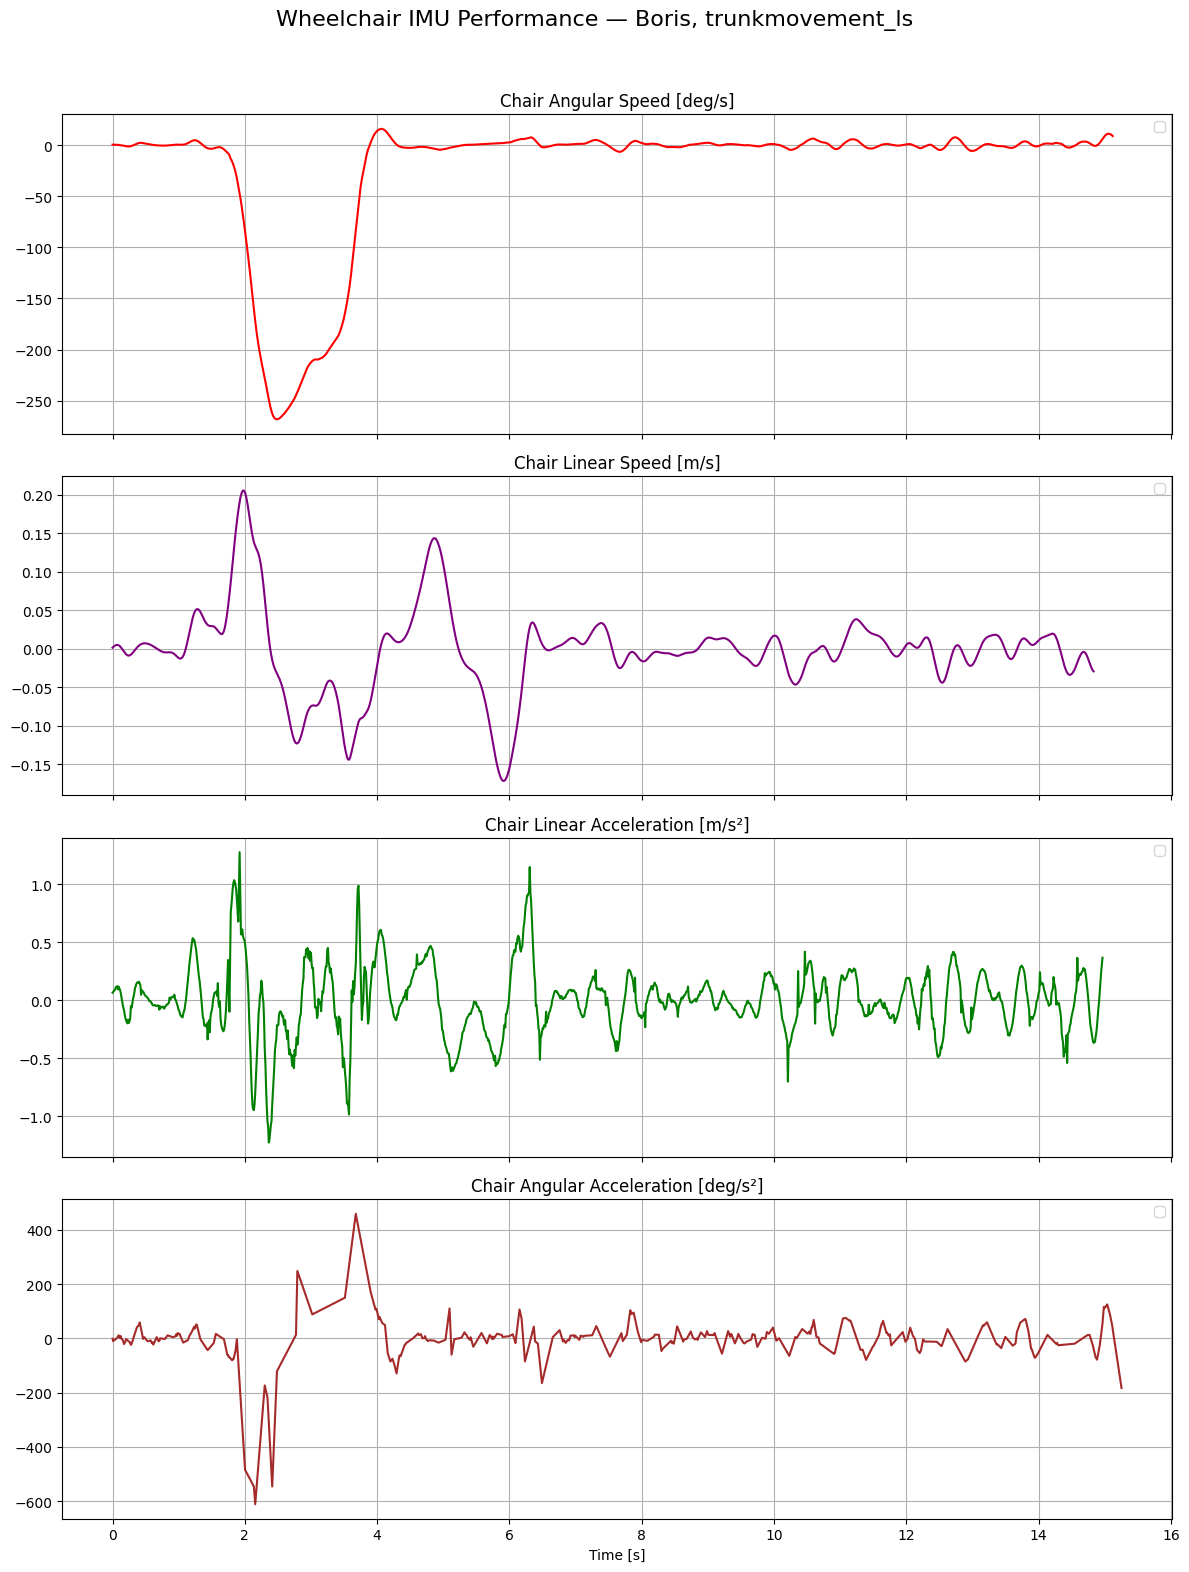

In [4]:
# === 1. Preprocess data ===
imu_data, opti_data = mf.preprocess_single_trial(subject, test_name, speed, test_date, dir)

# === 2. Extract raw IMU data for performance computation ===
imu_folder = os.path.join(dir, f'test_{test_date}/{subject}/imu/{subject}_{test_name}_{speed}')
imu_raw_data, imu_meta = mf.load_imu_data(imu_folder)

imu3_rot_matrix = np.stack(imu_raw_data['x-imu3']['rot_matrix'])
chair_rot_matrix = np.stack(imu_raw_data['chair']['rot_matrix'])

# Optional: Apply unwrap (you could also just use your correction function if better)
imu3_euler = R.from_matrix(imu3_rot_matrix).as_euler('xyz', degrees=True)
chair_euler = R.from_matrix(chair_rot_matrix).as_euler('xyz', degrees=True)

imu3_euler_unwrapped = np.unwrap(imu3_euler, discont=np.radians(360), axis=0)
chair_euler_unwrapped = np.unwrap(chair_euler, discont=np.radians(360), axis=0)

imu_fs = imu_meta['sampling_freq']['x-imu3']

# === 3. Compute performance metrics and get filtered signals ===
perf_max, perf_avg, perf_signals = mf.compute_performance(
    imu3_euler_unwrapped, chair_euler_unwrapped, imu_fs=imu_fs
)

# Unpack performance signals
chair_ang_vel = perf_signals['chair_ang_vel']
chair_linear_vel = perf_signals['chair_linear_vel']
chair_linear_acc = perf_signals['chair_linear_acc']
chair_ang_acc = perf_signals['chair_ang_acc']

# === 4. Generate Time Axes ===
t = lambda signal: np.arange(len(signal)) / imu_fs  # time generator

# === 5. Plot all signals ===
fig, axs = plt.subplots(4, 1, figsize=(12, 16), sharex=True)
fig.suptitle(f'Wheelchair IMU Performance — {subject}, {test_name}_{speed}', fontsize=16)

axs[0].plot(t(chair_ang_vel), chair_ang_vel, color='red')
axs[0].set_title('Chair Angular Speed [deg/s]'); axs[0].grid(True)

axs[1].plot(t(chair_linear_vel), chair_linear_vel, color='purple')
axs[1].set_title('Chair Linear Speed [m/s]'); axs[1].grid(True)

axs[2].plot(t(chair_linear_acc), chair_linear_acc, color='green')
axs[2].set_title('Chair Linear Acceleration [m/s²]'); axs[2].grid(True)

axs[3].plot(t(chair_ang_acc), chair_ang_acc, color='brown')
axs[3].set_title('Chair Angular Acceleration [deg/s²]'); axs[3].set_xlabel('Time [s]')
axs[3].grid(True)

for ax in axs:
    ax.legend()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## Main Trunk Motion, Performance, and Classification Analysis

In [5]:
summary_df = mf.aggregate_performance_metrics(
    subjects_pro, tests, speeds, rigid_bodies, dir, test_date_pro
)

Time shift = 246
Time shift = 106
Time shift = 92 samples
Time shift = 140 samples
Time shift = 186 samples
Time shift = 205
Time shift = 185
Time shift = 200
Time shift = 196 samples
Time shift = 129 samples
Time shift = 184 samples
Time shift = 18 samples
Time shift = 148 samples
Time shift = 171 samples
Time shift = 207
Time shift = 216 samples
Time shift = 417
Time shift = 20 samples
Time shift = 359 samples
Time shift = 161 samples
Time shift = 271 samples
Time shift = 741 samples
Time shift = 314 samples
Time shift = -12 samples
Time shift = 97
Time shift = 117
Time shift = 37 samples
Time shift = 166
Time shift = 208 samples
Time shift = 254
Time shift = 233
Time shift = 87
Time shift = 132 samples
Time shift = 223 samples
Time shift = 130 samples
Time shift = -53 samples
Time shift = 218
Time shift = 237
Time shift = 78
Time shift = 87
Time shift = 243 samples
Time shift = 240 samples
Time shift = 115
Time shift = 133
Time shift = 158
Time shift = 201
Time shift = 104 samples
T

In [6]:
# Add classification level to summary metrics

# Classification
classification = {
    'Fee': 1,
    'Fabian': 3,
    'Floris': 2.5,
    'Yinhu': 4.5,
    'Hidde': 4,
    'Vigo': 1,
    'Boris': 3.5,
    'Rinske': 4.5
}

# Add to summary_df
summary_df['classification'] = summary_df['subject'].map(classification)

## Correlations

### Correlation Trunk Motion & Performance Metrics

In [7]:
# Names of the performance metrics to be used in the analysis
performance_metrics = [
    'max_chair_ang_vel', 'max_chair_ang_acc',
    'max_chair_linear_vel', 'max_chair_linear_acc'
]

# Names of the trunk metrics to be used in the analysis
trunk_metrics = [
    'rom_imu', 'mean_angle_imu',
    'mean_ang_vel_imu', 'forward_time_imu_s'
]

In [8]:
# Initialize dictionary to store correlation results
correlation_results = []

# Unique test types and subject names
test_types = summary_df['test'].unique()
subject_names = subjects_pro

# Color map for subjects
colors = plt.cm.get_cmap('tab10', len(subject_names))
subject_colors = {subject: colors(i % 10) for i, subject in enumerate(subject_names)}

# Marker map for speed
speed_marker = {
    'hs': '^',  # triangle
    'ls': 'o'    # circle
}

# Output PDF
with PdfPages("trunk_vs_performance_plots_by_test.pdf") as pdf:
    for trunk, perf in itertools.product(trunk_metrics, performance_metrics):
        fig, axes = plt.subplots(2, 4, figsize=(20, 10), sharex=False, sharey=False)
        axes = axes.flatten()
        global_x, global_y = [], []

        all_subsets = {}
        for test in test_types:
            test_data = []
            for subject in subject_names:
                for speed in speeds:
                    subset = summary_df[
                        (summary_df['sensor'] == 'back') &
                        (summary_df['test'] == test) &
                        (summary_df['subject'] == subject) &
                        (summary_df['speed'] == speed)
                    ]
                    test_data.append((subject, speed, subset))
                    global_x.extend(subset[trunk])
                    global_y.extend(subset[perf])
            all_subsets[test] = test_data

        # Compute global axis limits
        if global_x and global_y:
            x_min, x_max = min(global_x), max(global_x)
            y_min, y_max = min(global_y), max(global_y)

            y_margin = (y_max - y_min) * 0.05
            x_margin = (x_max - x_min) * 0.05

            x_limits = (x_min - x_margin, x_max + x_margin)
            y_limits = (y_min - y_margin, y_max + y_margin)
        else:
            x_min = x_max = y_min = y_max = 0

        for idx, test in enumerate(test_types):
            ax = axes[idx]
            all_x, all_y = [], []

            for subject, speed, subset in all_subsets[test]:
                x = subset[trunk]
                y = subset[perf]
                if not subset.empty:
                    ax.scatter(x, y, 
                               color=subject_colors[subject], 
                               marker=speed_marker[speed], 
                               alpha=0.7, s=100)
                    all_x.extend(x)
                    all_y.extend(y)

            # Correlation line if enough data
            if len(all_x) > 1 and len(set(all_x)) > 1 and len(set(all_y)) > 1:
                corr, pval = pearsonr(all_x, all_y)
                slope, intercept = np.polyfit(all_x, all_y, 1)
                x_vals = np.array([x_min, x_max])
                y_vals = slope * x_vals + intercept
                ax.plot(x_vals, y_vals, '--', color='black', linewidth=1)
                corr_text = f"(r = {corr:.2f} p = {pval:.4f})"
                
                # >>> Store result in your dictionary
                correlation_results.append({
                    'test': test,
                    'trunk_metric': trunk,
                    'performance_metric': perf,
                    'r_value': corr,
                    'p_value': pval
                })
            else:
                corr_text = ""
                
                # Store NaN result so table has full structure
                correlation_results.append({
                    'test': test,
                    'trunk_metric': trunk,
                    'performance_metric': perf,
                    'r_value': np.nan,
                    'p_value': np.nan
                })

            ax.set_xlim(x_limits)
            ax.set_ylim(y_limits)
            ax.set_title(f"{test} {corr_text}")
            ax.set_xlabel(trunk)
            ax.set_ylabel(perf)
            ax.grid(True)

        # Custom speed markers
        ls_marker = mlines.Line2D([], [], color='black', marker='o', linestyle='None', markersize=10, label='Low Speed')
        hs_marker = mlines.Line2D([], [], color='black', marker='^', linestyle='None', markersize=10, label='High Speed')

        # Subject handles
        subject_markers = [
            mlines.Line2D([], [], color=subject_colors[s], marker='o', linestyle='None', markersize=10, label=s)
            for s in subject_names
        ]

        # Combine legends
        all_handles = subject_markers + [ls_marker, hs_marker]
        all_labels = [s for s in subject_names] + ['Low Speed', 'High Speed']

        # Place the combined legend above the title
        fig.legend(all_handles, all_labels, title="Legend", loc='upper center', ncol=len(subject_names) + 2, bbox_to_anchor=(0.5, 1.05))

        fig.suptitle(f"{trunk} vs {perf}", fontsize=16)
        fig.tight_layout(rect=[0, 0, 1, 0.95])
        pdf.savefig(fig, bbox_inches='tight')
        plt.close(fig)

/var/folders/m3/kj_wr6p11r90gfg0m9l9xc4w0000gn/T/ipykernel_53408/1171898960.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(subject_names))


### Correlation Trunk Motion and Classification

/var/folders/m3/kj_wr6p11r90gfg0m9l9xc4w0000gn/T/ipykernel_53408/2897775155.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(subjects_pro))


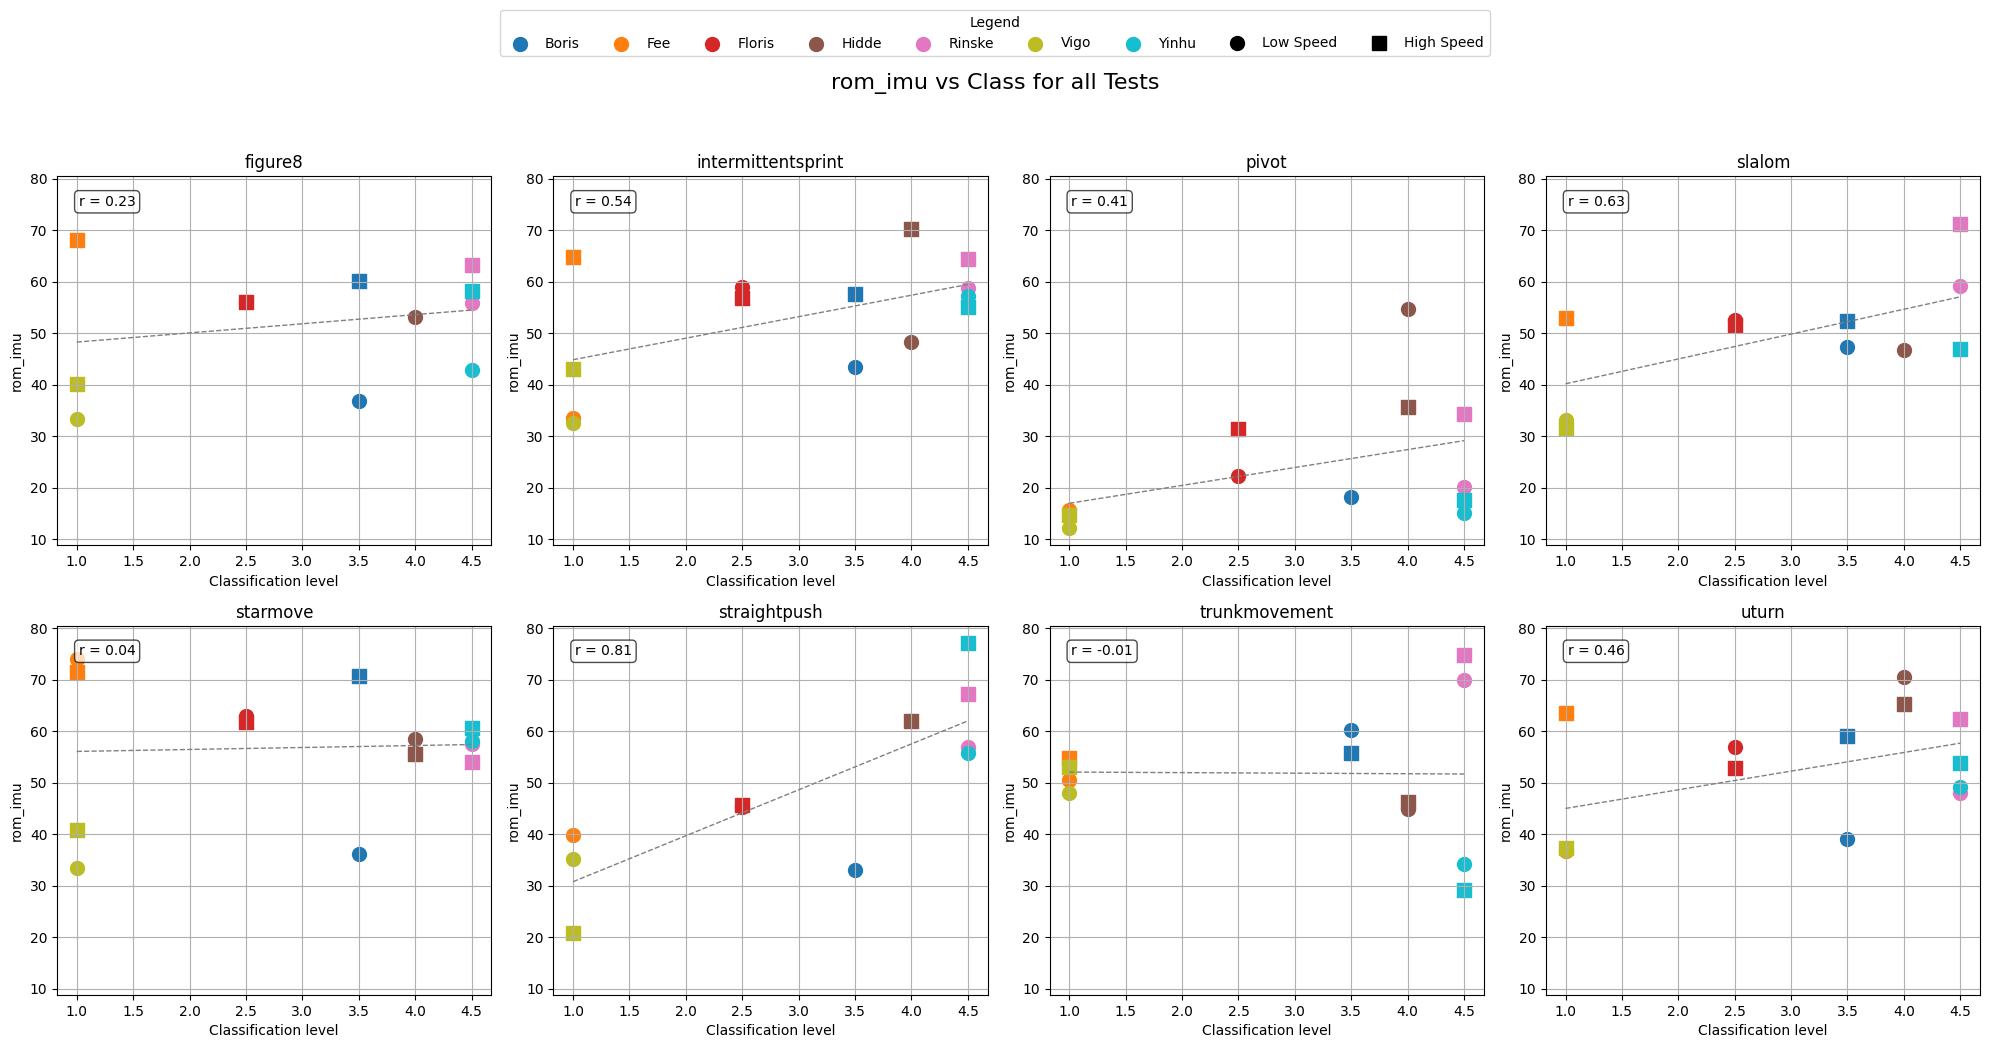

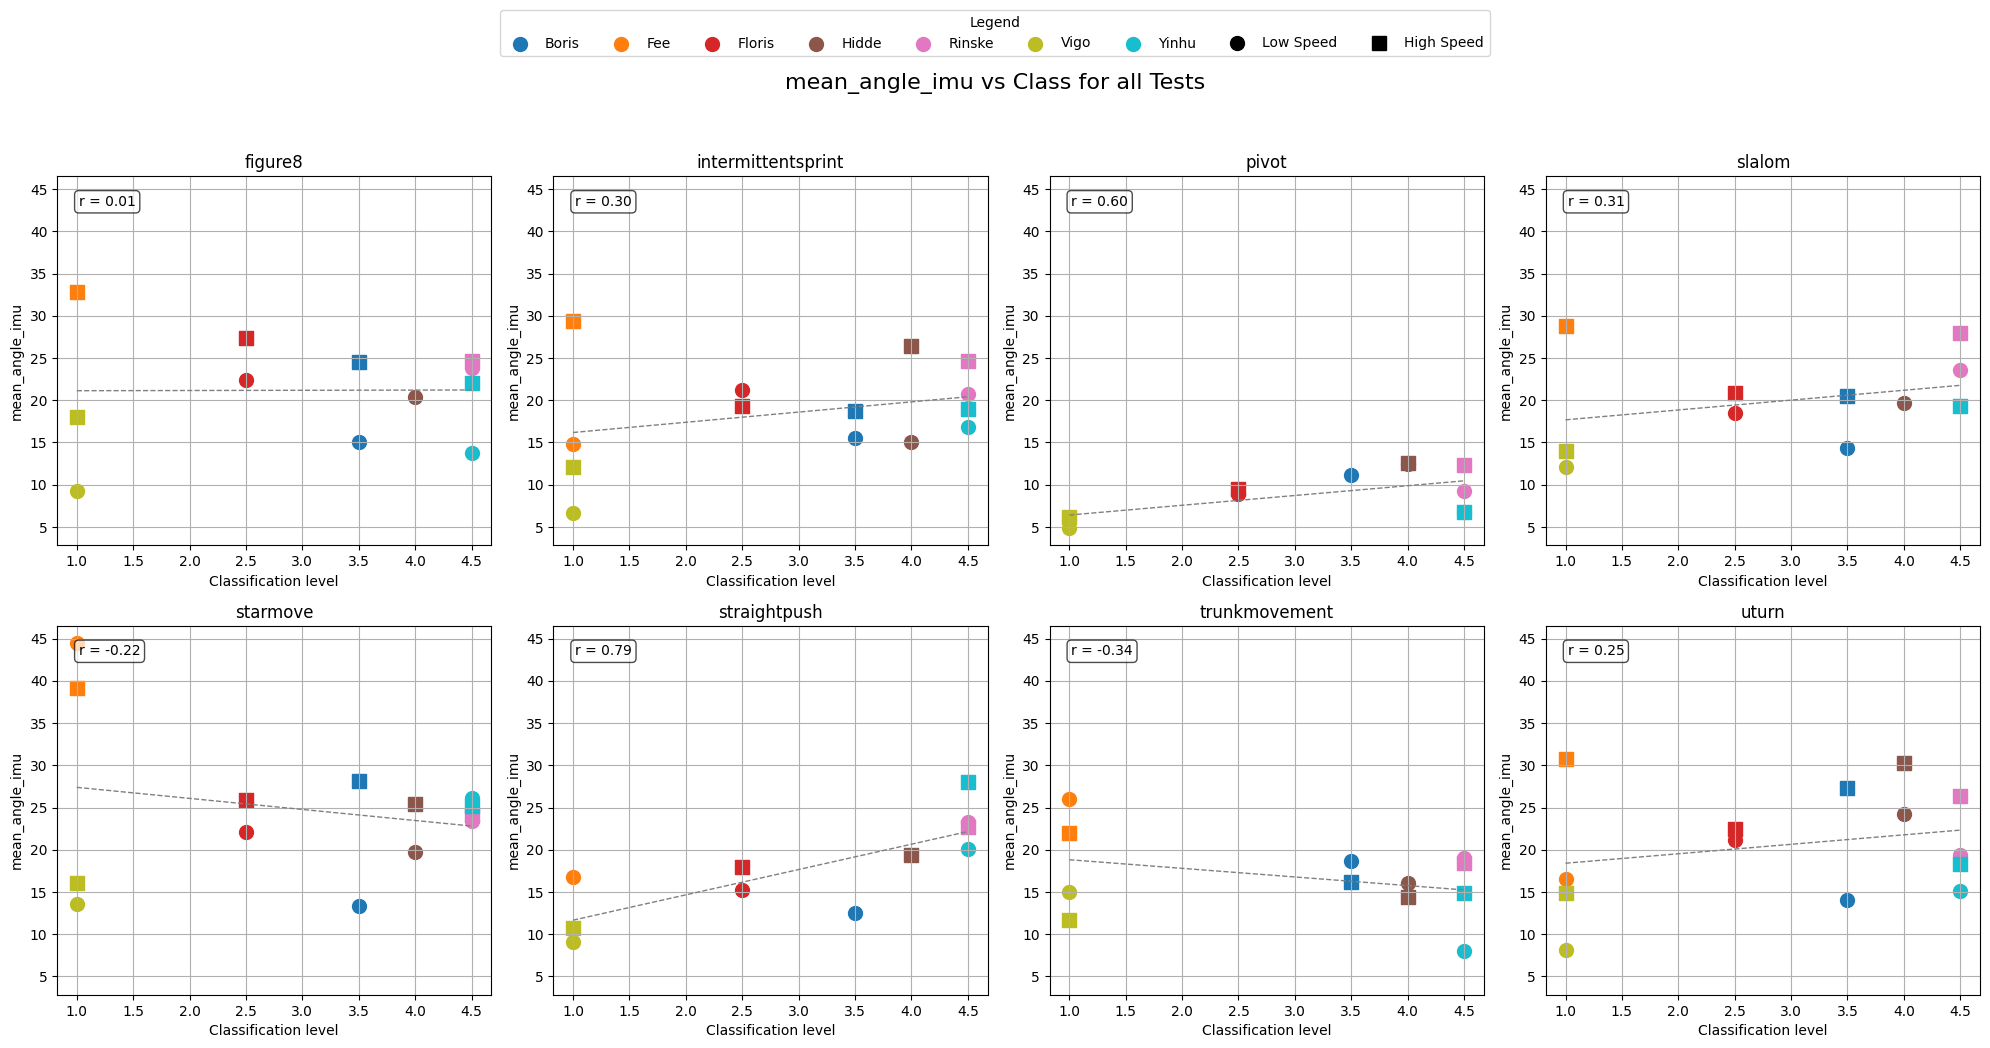

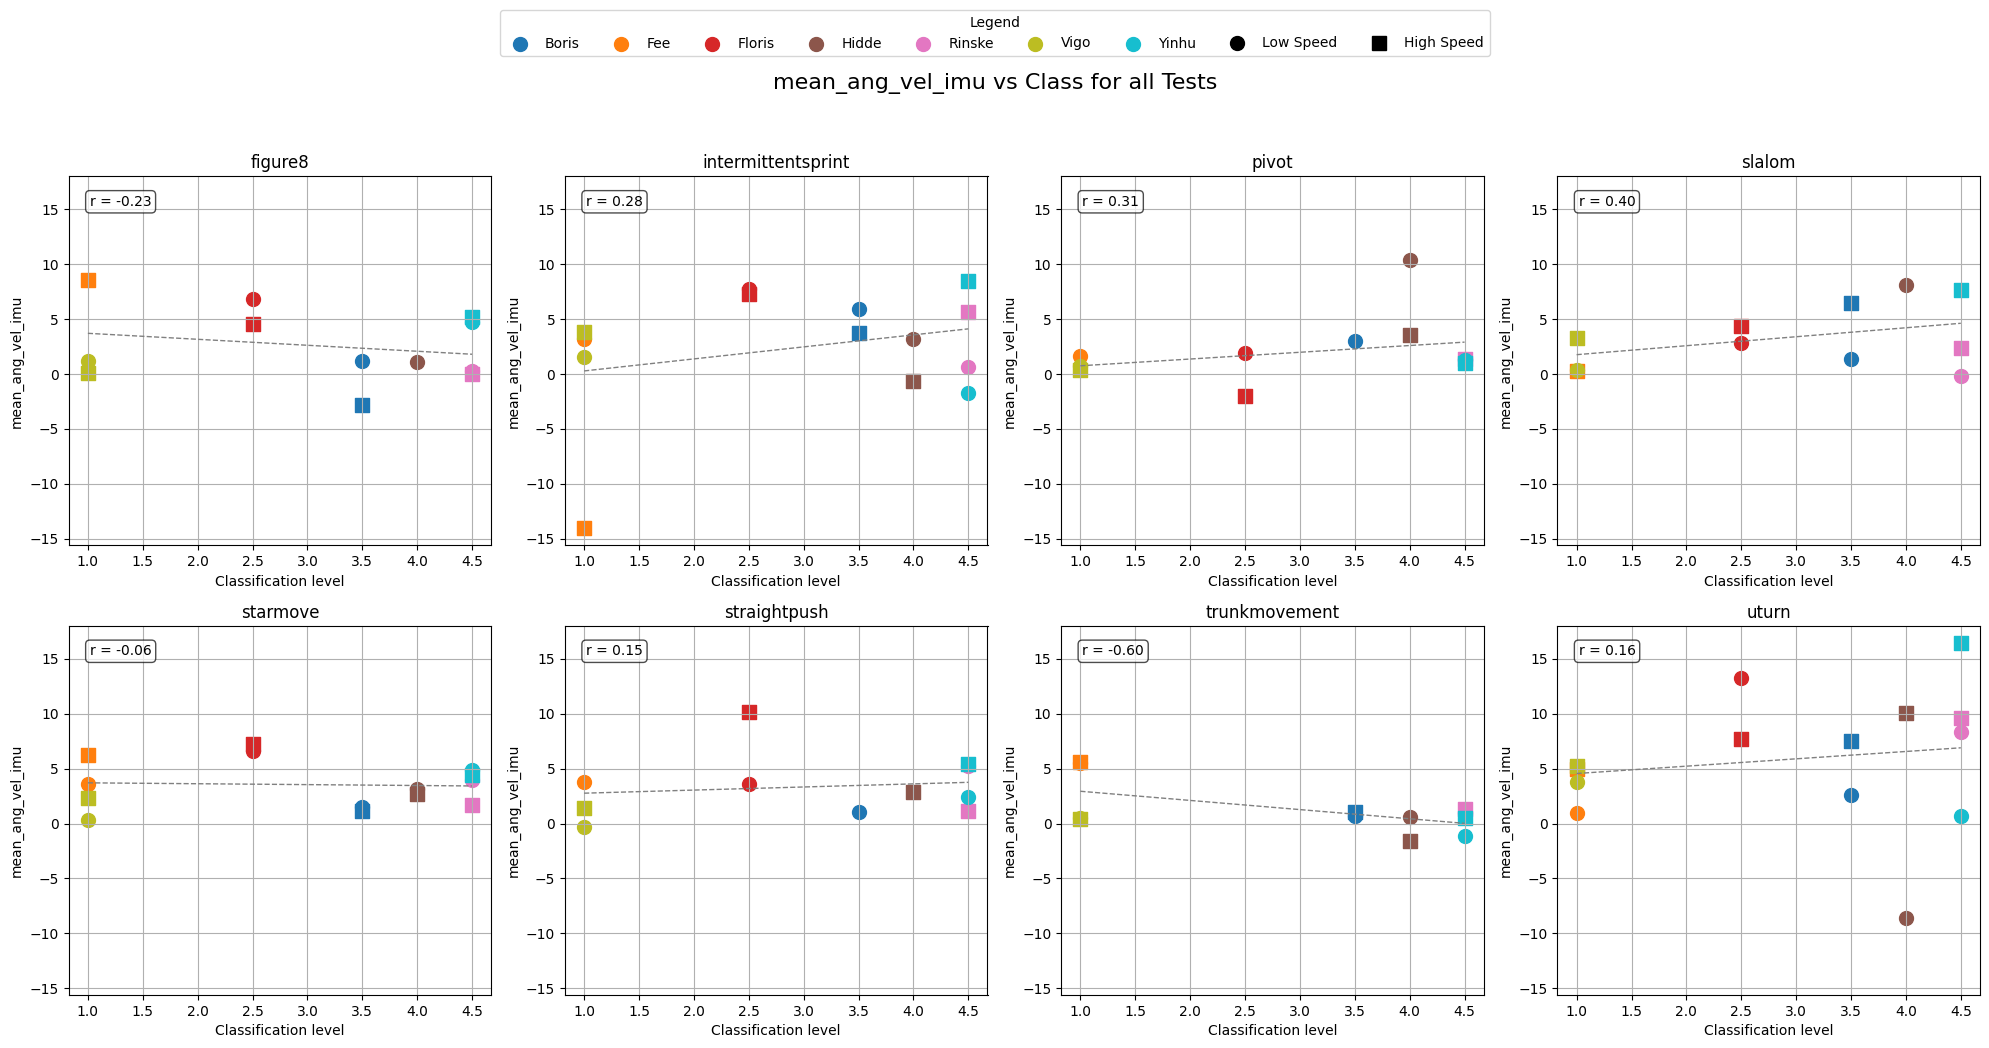

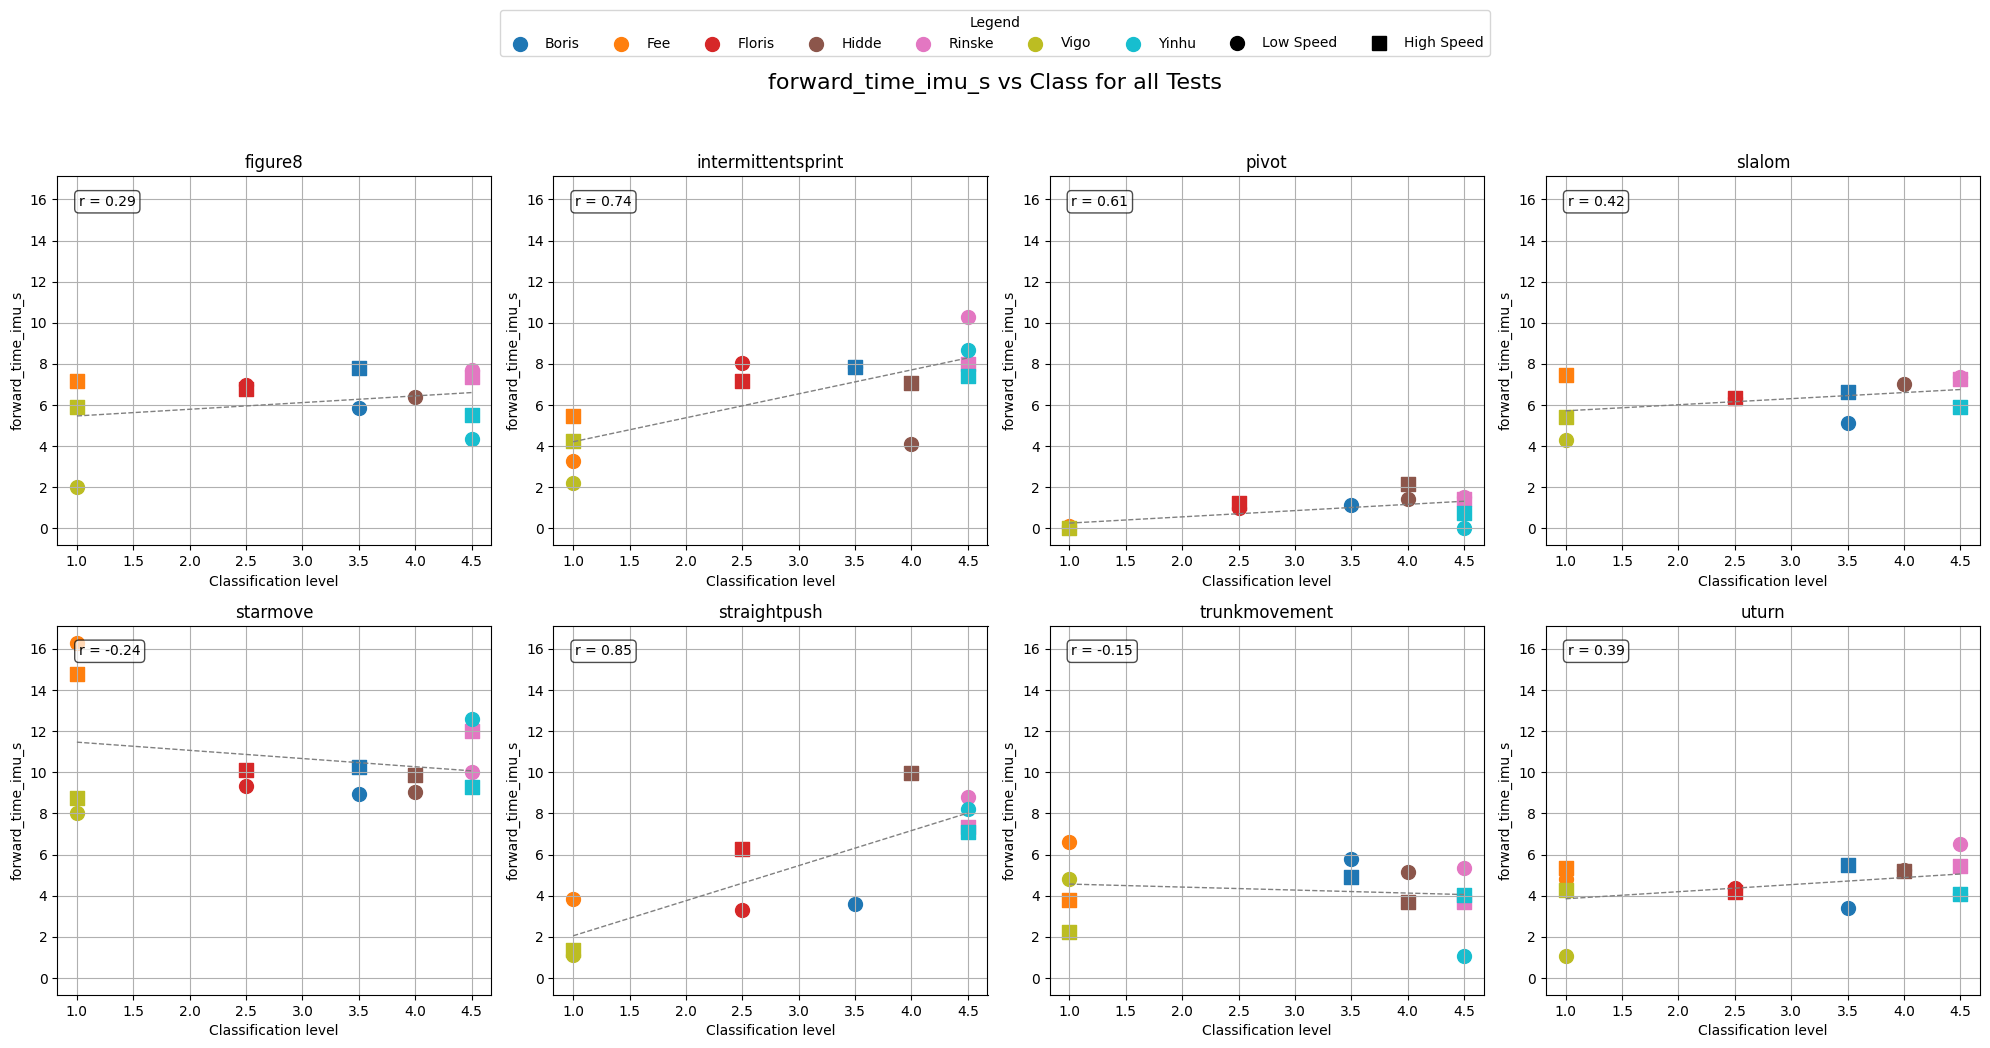

In [9]:
# Define marker styles for speeds and colors
marker_styles = {'ls': 'o', 'hs': 's'}
colors = plt.cm.get_cmap('tab10', len(subjects_pro))

# Loop over trunk metrics
for trunk_metric in trunk_metrics:
    # Calculate global y-axis limits for this trunk_metric
    metric_values = summary_df[
        (summary_df['sensor'] == 'back') & 
        (summary_df['test'].isin(tests))
    ][trunk_metric].dropna()
    y_min = metric_values.min()
    y_max = metric_values.max()

    # Optional: add some margin so markers don’t sit on the edges
    y_margin = (y_max - y_min) * 0.05
    y_limits = (y_min - y_margin, y_max + y_margin)

    # Create one figure with 8 subplots (2 rows x 4 columns)
    fig, axs = plt.subplots(2, 4, figsize=(20, 10))
    axs = axs.flatten()  # Flatten to easily index

    for idx, test in enumerate(tests):
        ax = axs[idx]

        test_df = summary_df[
            (summary_df['test'] == test) &
            (summary_df['sensor'] == 'back')
        ][['subject', 'speed', trunk_metric, 'classification']]

        for i, subject in enumerate(subjects_pro):
            for speed in ['ls', 'hs']:
                subset = test_df[
                    (test_df['subject'] == subject) &
                    (test_df['speed'] == speed)
                ]
                ax.scatter(
                    subset['classification'], subset[trunk_metric],
                    label=subject if speed == 'ls' else "",  # Avoid duplicate legend entries
                    c=[colors(i)], marker=marker_styles[speed], s=100
                )

        # Correlation and trend line
        if len(test_df) >= 2:
            x = test_df['classification']
            y = test_df[trunk_metric]
            r, _ = pearsonr(x, y)
            ax.text(0.05, 0.95, f'r = {r:.2f}', transform=ax.transAxes,
                    ha='left', va='top', fontsize=10, bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

            # Regression line
            coeffs = np.polyfit(x, y, 1)
            x_vals = np.array([x.min(), x.max()])
            y_vals = np.polyval(coeffs, x_vals)
            ax.plot(x_vals, y_vals, color='gray', linestyle='--', linewidth=1)

        ax.set_title(f'{test}')
        ax.set_xlabel('Classification level')
        ax.set_ylim(y_limits)
        ax.set_ylabel(trunk_metric)
        ax.grid(True)

    # Create custom legend handles for speed markers
    ls_marker = mlines.Line2D([], [], color='black', marker='o', linestyle='None',
                              markersize=10, label='Low Speed')
    hs_marker = mlines.Line2D([], [], color='black', marker='s', linestyle='None',
                              markersize=10, label='High Speed')

    # Subject handles from the last subplot
    handles_subj, labels_subj = ax.get_legend_handles_labels()
    # Combine legends
    all_handles = handles_subj + [ls_marker, hs_marker]
    all_labels = labels_subj + ['Low Speed', 'High Speed']

    # Plot the combined legend above all subplots
    fig.legend(all_handles, all_labels, title="Legend", loc='upper center',
               ncol=len(subjects_pro) + 2, bbox_to_anchor=(0.5, 1.05))
    fig.suptitle(f'{trunk_metric} vs Class for all Tests', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

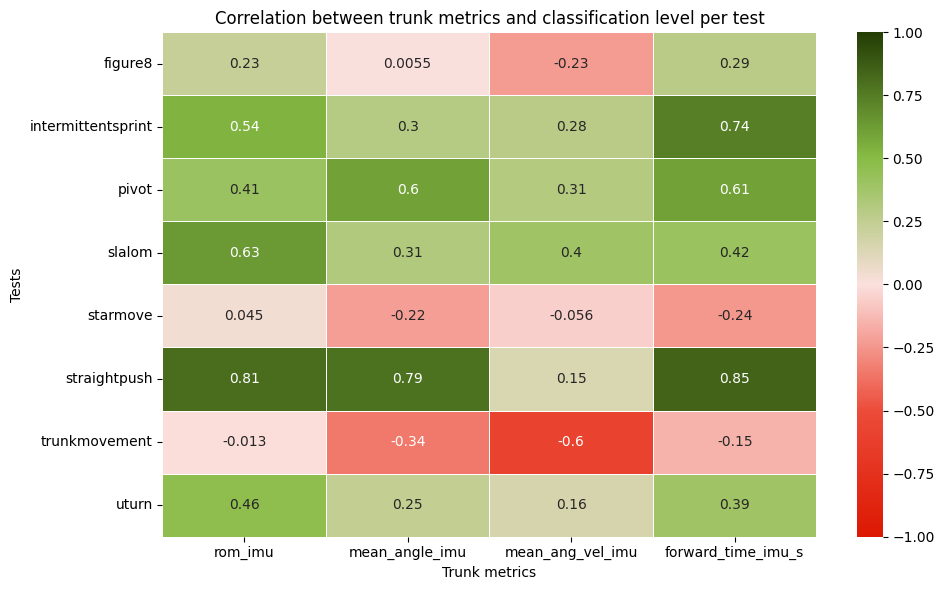

In [10]:
# Create custom colormap from your palette
diverging_colors = ["#dd1802", "#ec4c3a", "#fbe0de", "#87bc45", "#243D05"]
custom_cmap = LinearSegmentedColormap.from_list("red_green_diverging", diverging_colors, N=256)

# Create an empty DataFrame to store correlation coefficients
correlation_matrix = pd.DataFrame(index=tests, columns=trunk_metrics)

# Calculate correlations
for test in tests:
    for metric in trunk_metrics:
        test_df = summary_df[
            (summary_df['test'] == test) &
            (summary_df['sensor'] == 'back')
        ][['classification', metric]].dropna()

        if len(test_df) >= 2:
            r, _ = pearsonr(test_df['classification'], test_df[metric])
            correlation_matrix.loc[test, metric] = r
        else:
            correlation_matrix.loc[test, metric] = np.nan

# Convert to float for proper heatmap scaling
correlation_matrix = correlation_matrix.astype(float)

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap=custom_cmap, center=0, vmin=-1, vmax=1, linewidths=0.5)
plt.title('Correlation between trunk metrics and classification level per test')
plt.xlabel('Trunk metrics')
plt.ylabel('Tests')
plt.tight_layout()
plt.show()

### Correlation Performance and Classification

/var/folders/m3/kj_wr6p11r90gfg0m9l9xc4w0000gn/T/ipykernel_53408/3774890251.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(subjects_pro))


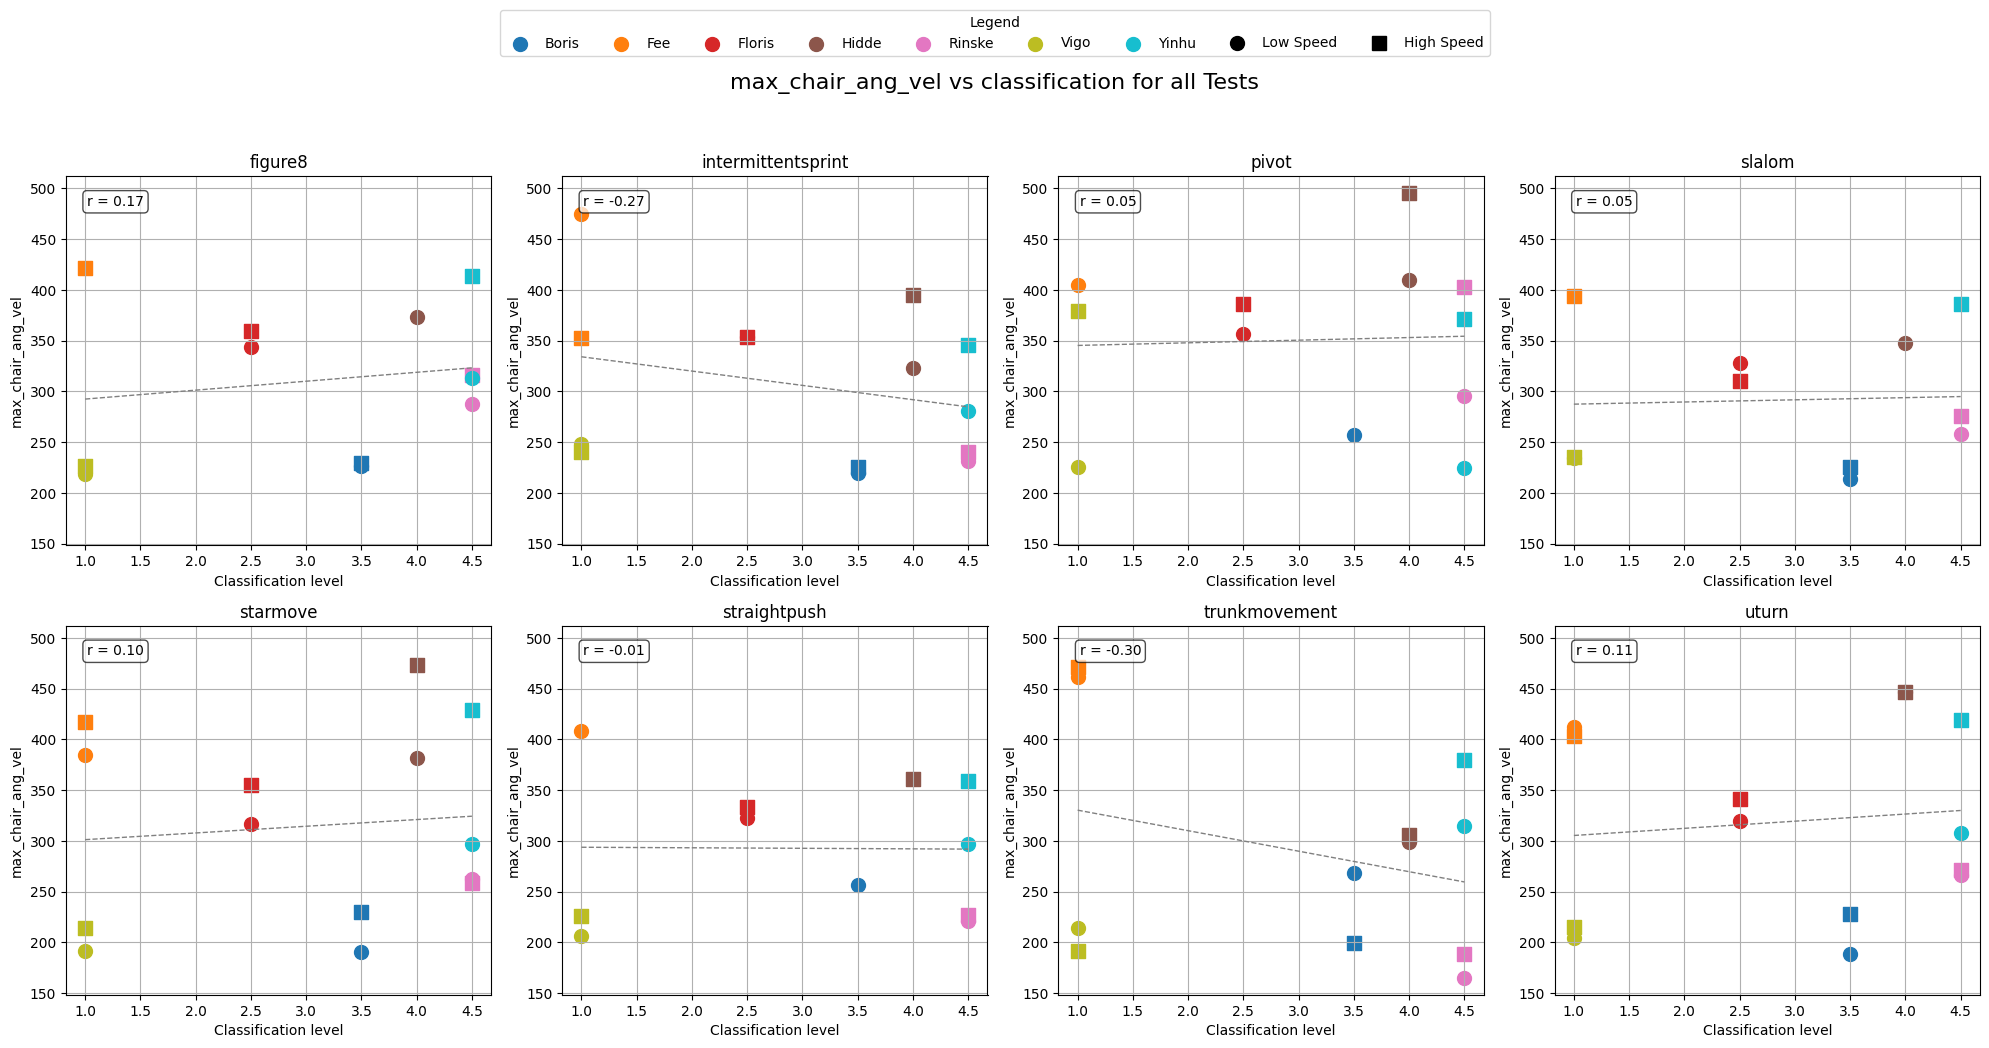

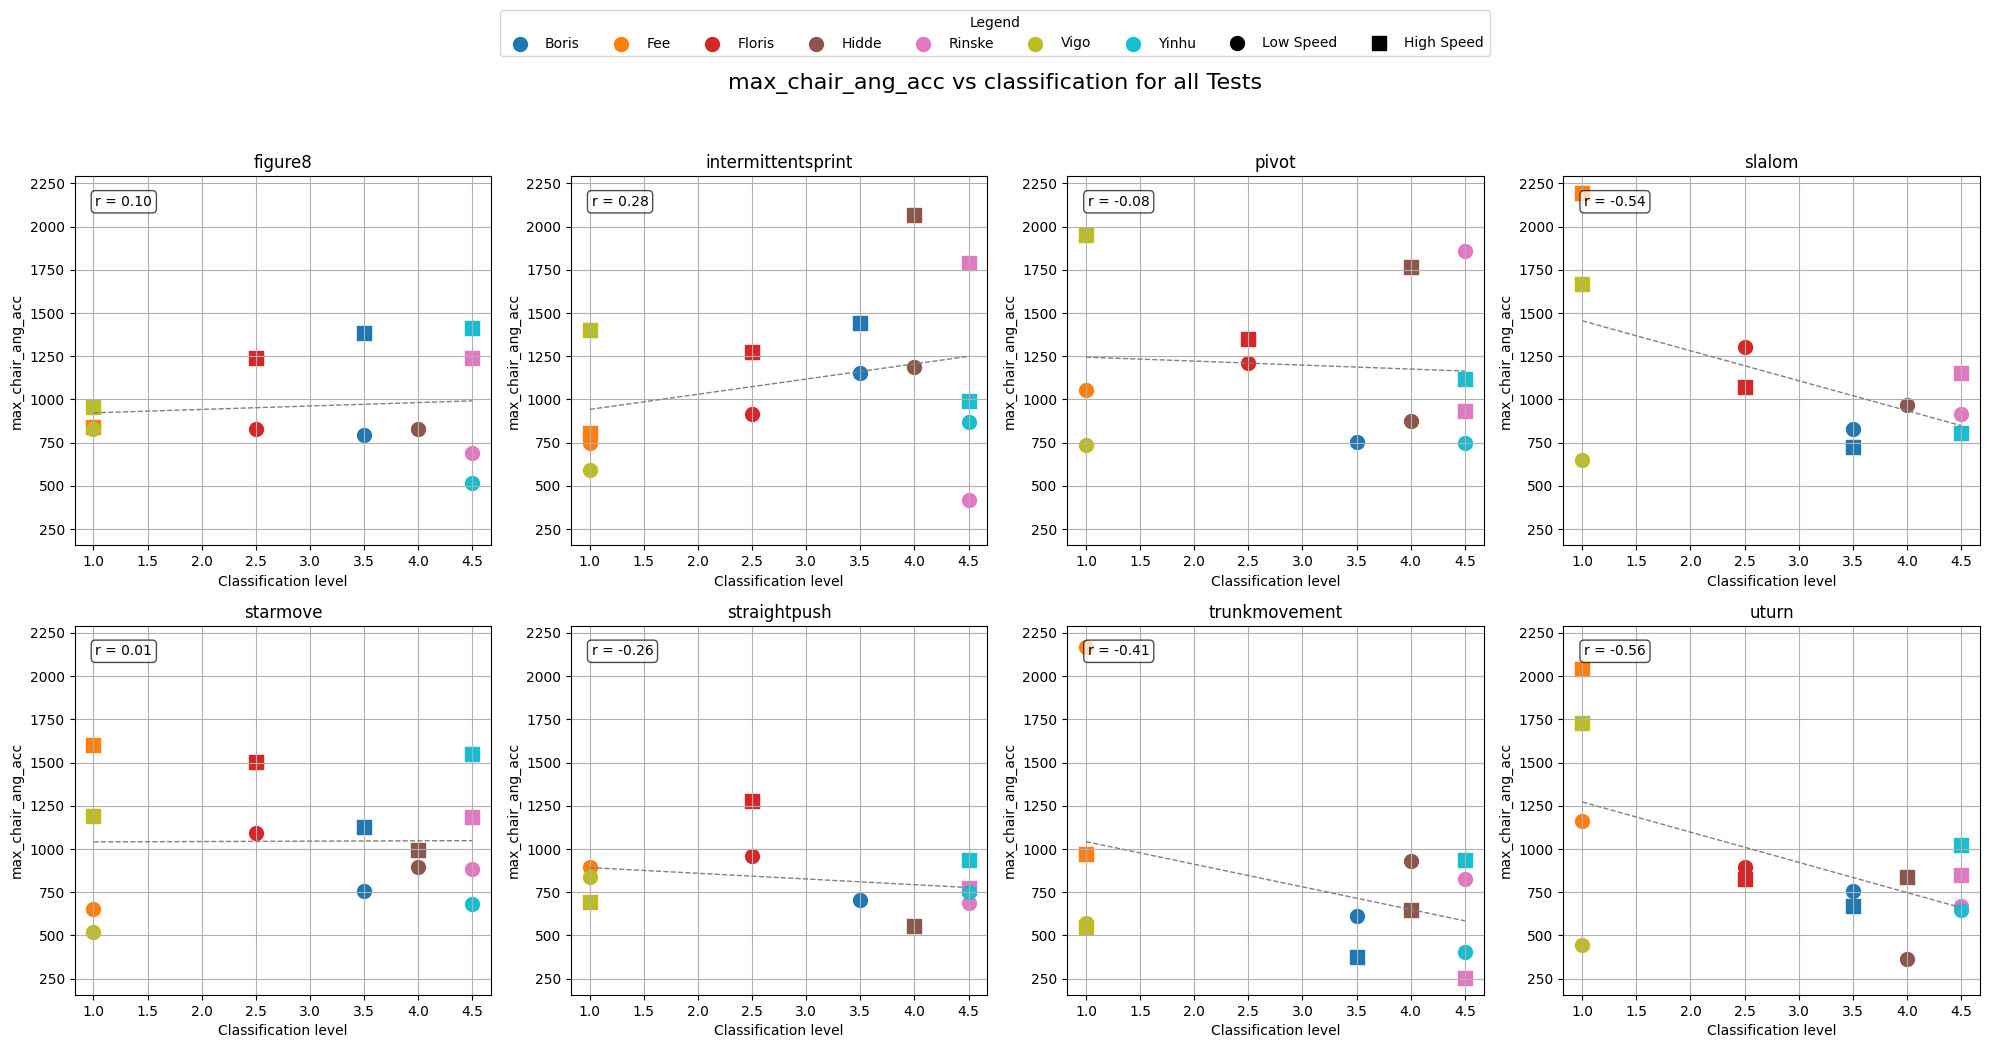

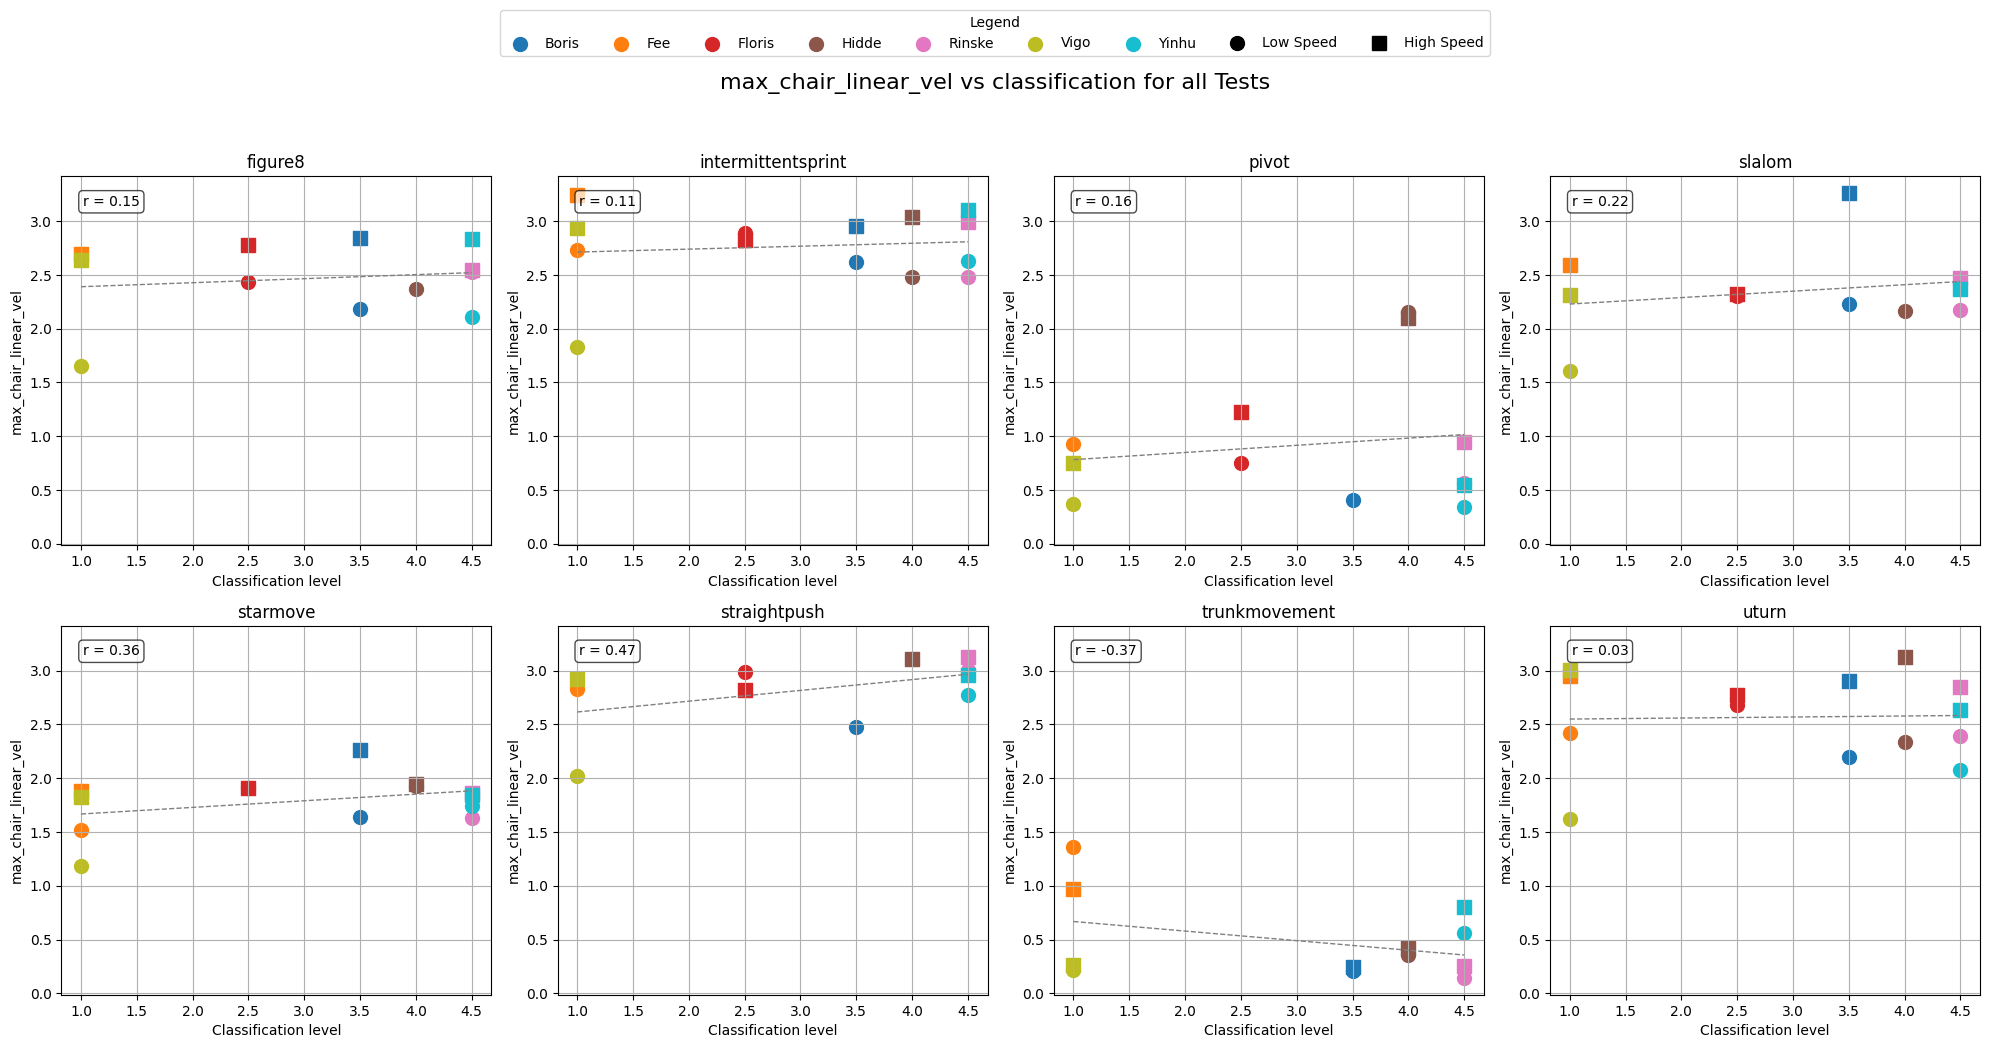

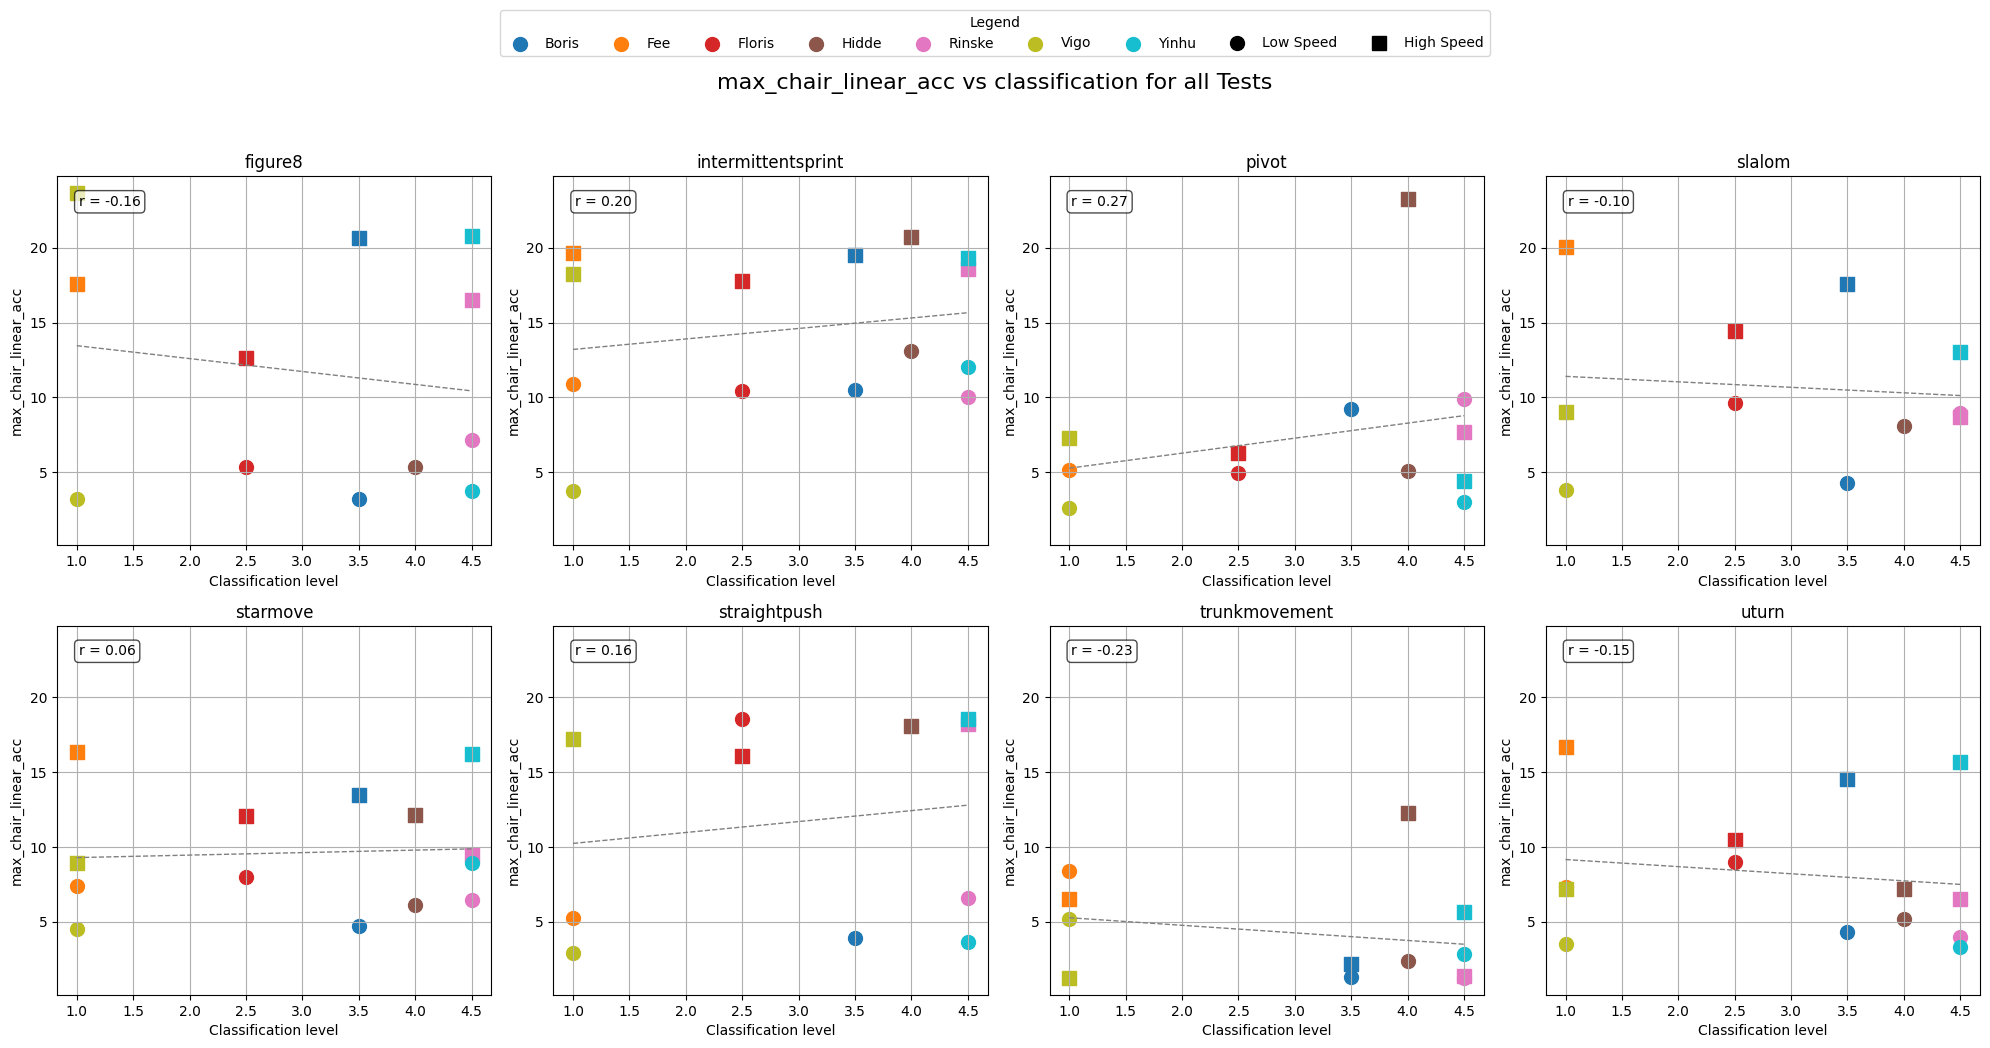

In [11]:
# Define marker styles for speeds and colors
marker_styles = {'ls': 'o', 'hs': 's'}
colors = plt.cm.get_cmap('tab10', len(subjects_pro))

# Loop over performance metrics
for perf_metric in performance_metrics:
    # Calculate global y-axis limits for this perf_metric
    metric_values = summary_df[
        (summary_df['sensor'] == 'back') & 
        (summary_df['test'].isin(tests))
    ][perf_metric].dropna()
    y_min = metric_values.min()
    y_max = metric_values.max()

    # Optional: add some margin so markers don’t sit on the edges
    y_margin = (y_max - y_min) * 0.05
    y_limits = (y_min - y_margin, y_max + y_margin)

    # Create one figure with 8 subplots (2 rows x 4 columns)
    fig, axs = plt.subplots(2, 4, figsize=(20, 10))
    axs = axs.flatten()  # Flatten to easily index

    for idx, test in enumerate(tests):
        ax = axs[idx]

        test_df = summary_df[
            (summary_df['test'] == test) &
            (summary_df['sensor'] == 'back')
        ][['subject', 'speed', perf_metric, 'classification']]

        for i, subject in enumerate(subjects_pro):
            for speed in ['ls', 'hs']:
                subset = test_df[
                    (test_df['subject'] == subject) &
                    (test_df['speed'] == speed)
                ]
                ax.scatter(
                    subset['classification'], subset[perf_metric],
                    label=subject if speed == 'ls' else "",  # Avoid duplicate legend entries
                    c=[colors(i)], marker=marker_styles[speed], s=100
                )

        # Correlation and trend line
        if len(test_df) >= 2:
            x = test_df['classification']
            y = test_df[perf_metric]
            r, _ = pearsonr(x, y)
            ax.text(0.05, 0.95, f'r = {r:.2f}', transform=ax.transAxes,
                    ha='left', va='top', fontsize=10, bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

            # Regression line
            coeffs = np.polyfit(x, y, 1)
            x_vals = np.array([x.min(), x.max()])
            y_vals = np.polyval(coeffs, x_vals)
            ax.plot(x_vals, y_vals, color='gray', linestyle='--', linewidth=1)

        ax.set_title(f'{test}')
        ax.set_xlabel('Classification level')
        ax.set_ylim(y_limits)
        ax.set_ylabel(perf_metric)
        ax.grid(True)

    # Create custom legend handles for speed markers
    ls_marker = mlines.Line2D([], [], color='black', marker='o', linestyle='None',
                              markersize=10, label='Low Speed')
    hs_marker = mlines.Line2D([], [], color='black', marker='s', linestyle='None',
                              markersize=10, label='High Speed')

    # Subject handles from the last subplot
    handles_subj, labels_subj = ax.get_legend_handles_labels()
    # Combine legends
    all_handles = handles_subj + [ls_marker, hs_marker]
    all_labels = labels_subj + ['Low Speed', 'High Speed']

    # Plot the combined legend above all subplots
    fig.legend(all_handles, all_labels, title="Legend", loc='upper center',
               ncol=len(subjects_pro) + 2, bbox_to_anchor=(0.5, 1.05))
    fig.suptitle(f'{perf_metric} vs classification for all Tests', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

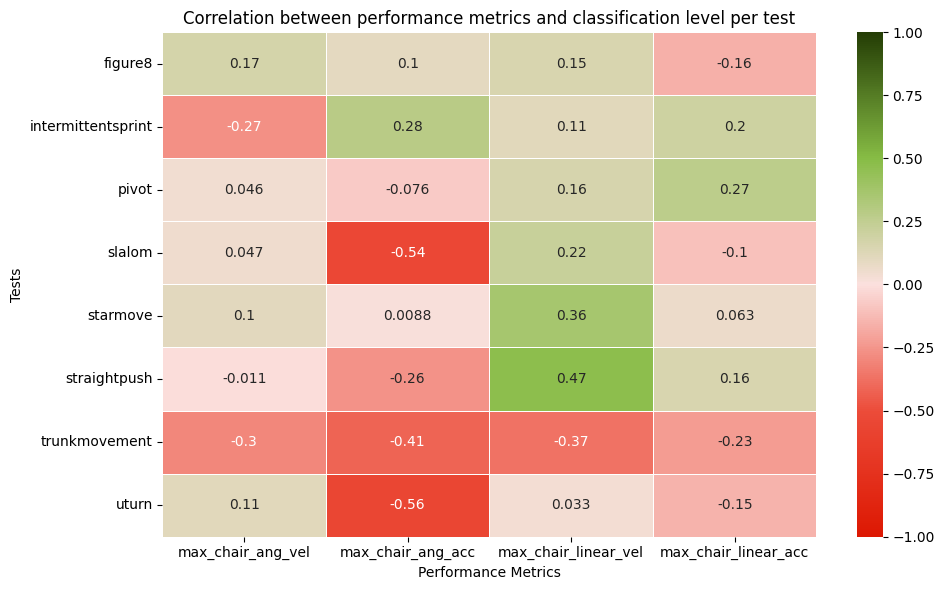

In [12]:
# Create an empty DataFrame to store correlation coefficients
perf_corr_matrix = pd.DataFrame(index=tests, columns=performance_metrics)

# Calculate correlations
for test in tests:
    for metric in performance_metrics:
        test_df = summary_df[
            (summary_df['test'] == test) &
            (summary_df['sensor'] == 'back')
        ][['classification', metric]].dropna()

        if len(test_df) >= 2:
            r, _ = pearsonr(test_df['classification'], test_df[metric])
            perf_corr_matrix.loc[test, metric] = r
        else:
            perf_corr_matrix.loc[test, metric] = np.nan

# Convert to float for proper heatmap scaling
perf_corr_matrix = perf_corr_matrix.astype(float)

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(perf_corr_matrix, annot=True, cmap=custom_cmap, center=0, vmin=-1, vmax=1, linewidths=0.5)
plt.title('Correlation between performance metrics and classification level per test')
plt.xlabel('Performance Metrics')
plt.ylabel('Tests')
plt.tight_layout()
plt.show()